In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
dir = "../data/"

In [3]:
# Read in the data for both imports and exports
df_imports = pd.read_csv(dir + "LivestockMeat_Imports.csv")
df_exports = pd.read_csv(dir + "LivestockMeat_Exports.csv")

# print head
print(df_imports.head(5))
print(df_exports.head(5))

print(df_imports.shape)
print(df_exports.shape)

   SOURCE_ID      HS_CODE                                     COMMODITY_DESC  \
0         58  102902012.0  Cows, live, imported for dairy purposes, weigh...   
1         58  102902012.0  Cows, live, imported for dairy purposes, weigh...   
2         58  102100050.0  Bovine animals, purebred breeding, except dair...   
3         58  102100050.0  Bovine animals, purebred breeding, except dair...   
4         58  102100050.0  Bovine animals, purebred breeding, except dair...   

   GEOGRAPHY_CODE GEOGRAPHY_DESC  ATTRIBUTE_DESC UNIT_DESC  YEAR_ID  \
0            1220         Canada  US Import, QTY        NO     1996   
1            1220         Canada  US Import, QTY        NO     1997   
2               1          World  US Import, QTY        NO     1994   
3               1          World  US Import, QTY        NO     1994   
4               1          World  US Import, QTY        NO     1994   

   TIMEPERIOD_ID  AMOUNT  
0             12   851.0  
1              1  1077.0  
2          

In [4]:
# group by year_id and sum over 'Amount' column to get total imports/exports per year
df_imports_year = df_imports.groupby(['YEAR_ID'])
df_exports_year = df_exports.groupby(['YEAR_ID'])

# create new dataframe with total imports/exports per year
dfs_imports_list = []
dfs_exports_list = []

# for each year, sum over 'Amount' column to get total imports/exports per year and save in the new dataframe
for year, group in df_imports_year:
    df_imports_tot_per_year = pd.DataFrame({'YEAR_ID': year, 'AMOUNT': group['AMOUNT'].sum()})
    dfs_imports_list.append(df_imports_tot_per_year)

for year, group in df_exports_year:
    df_exports_tot_per_year = pd.DataFrame({'YEAR_ID': year, 'AMOUNT': group['AMOUNT'].sum()})
    dfs_exports_list.append(df_exports_tot_per_year)

# convert list of dataframes to single dataframe
df_imports_yearly = pd.concat(dfs_imports_list)
df_exports_yearly = pd.concat(dfs_exports_list)

# print head
print(df_imports_yearly.head(5))
print(df_exports_yearly.head(5))

   YEAR_ID        AMOUNT
0     1989  1.702718e+10
0     1990  1.784900e+10
0     1991  1.741726e+10
0     1992  1.695237e+10
0     1993  1.731756e+10
   YEAR_ID        AMOUNT
0     1989  1.420746e+10
0     1990  1.457129e+10
0     1991  1.712753e+10
0     1992  2.043494e+10
0     1993  2.338679e+10


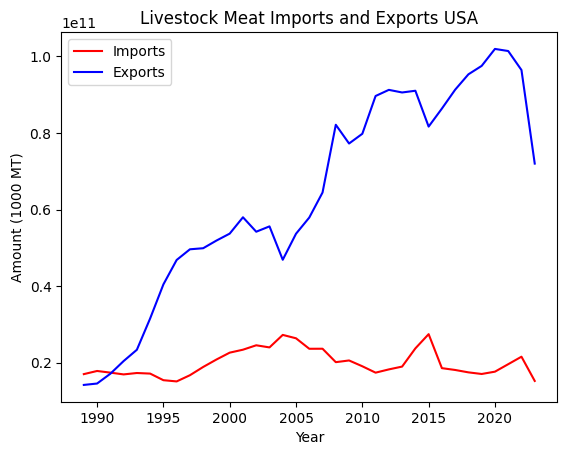

In [14]:
# make the year_id the index
meat_imports_df = df_imports_yearly.set_index('YEAR_ID')
meat_exports_df = df_exports_yearly.set_index('YEAR_ID')

# plot the data on the same graph with a legend, title, and axis labels
plt.plot(meat_imports_df, 'r', meat_exports_df, 'b')
plt.legend(['Imports', 'Exports'])
plt.title('Livestock Meat Imports and Exports USA')
plt.xlabel('Year')
plt.ylabel('Amount (1000 MT)')
plt.show()

In [15]:
# get the cpi data from the database
conn = sqlite3.connect('../food_inflation_analysis.db')
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
cpi_food_data.index = pd.to_datetime(cpi_food_data['Date'])
cpi_food_data.drop('Date', axis=1, inplace=True)
# print head
print(cpi_food_data.head(5))
conn.close()

            Inflation
Date                 
1956-01-01  -1.700680
1956-02-01  -2.372881
1956-03-01  -2.033898
1956-04-01  -1.689189
1956-05-01  -0.337838


In [22]:
# get the correlation between the cpi and the imports/exports
# align indexes of the dataframes
cpi_food_data_yearly = cpi_food_data.resample('Y').mean()
cpi_food_data_yearly.index = cpi_food_data_yearly.index.year
# align indexes of the dataframes
# align index name
meat_exports_df.index.name = 'Year'
meat_imports_df.index.name = 'Year'
cpi_food_data_yearly.index.name = 'Year'

# print head
print(cpi_food_data_yearly.head(5))
print(meat_exports_df.head(5))
print(meat_imports_df.head(5))

# inner join the dataframes
meat_exports_combined = meat_exports_df.join(cpi_food_data_yearly, how='inner', on='Year')
meat_imports_combined = meat_imports_df.join(cpi_food_data_yearly, how='inner', on='Year')

# lag import and export data by 1 year
meat_exports_lag = meat_exports_combined['AMOUNT'].shift(1)
meat_imports_lag = meat_imports_combined['AMOUNT'].shift(1)

# add lagged data to the dataframe
meat_exports_combined['AMOUNT_LAG'] = meat_exports_lag
meat_imports_combined['AMOUNT_LAG'] = meat_imports_lag

# drop the first row of the dataframe
meat_exports_combined.dropna(inplace=True)
meat_imports_combined.dropna(inplace=True)

# print head
print(meat_exports_combined.head(5))
print(meat_imports_combined.head(5))


      Inflation
Year           
1956   0.595752
1957   3.238256
1958   4.372906
1959  -2.383241
1960   0.913196
            AMOUNT
Year              
1989  1.420746e+10
1990  1.457129e+10
1991  1.712753e+10
1992  2.043494e+10
1993  2.338679e+10
            AMOUNT
Year              
1989  1.702718e+10
1990  1.784900e+10
1991  1.741726e+10
1992  1.695237e+10
1993  1.731756e+10
            AMOUNT  Inflation    AMOUNT_LAG
Year                                       
1990  1.457129e+10   6.536602  1.420746e+10
1991  1.712753e+10   2.674094  1.457129e+10
1992  2.043494e+10   0.729727  1.712753e+10
1993  2.338679e+10   2.363544  2.043494e+10
1994  3.155958e+10   2.873815  2.338679e+10
            AMOUNT  Inflation    AMOUNT_LAG
Year                                       
1990  1.784900e+10   6.536602  1.702718e+10
1991  1.741726e+10   2.674094  1.784900e+10
1992  1.695237e+10   0.729727  1.741726e+10
1993  1.731756e+10   2.363544  1.695237e+10
1994  1.716678e+10   2.873815  1.731756e+10


In [27]:
# Find correlation between cpi and imports/exports of current year
export_corr = meat_exports_combined['AMOUNT'].corr(meat_exports_combined['Inflation'], method='spearman')
import_corr = meat_imports_combined['AMOUNT'].corr(meat_imports_combined['Inflation'], method='spearman')

# Find correlation between cpi and imports/exports of previous year
export_corr_lag = meat_exports_combined['AMOUNT_LAG'].corr(meat_exports_combined['Inflation'])
import_corr_lag = meat_imports_combined['AMOUNT_LAG'].corr(meat_imports_combined['Inflation'])

print("Correlation between CPI and Exports: ", export_corr)
print("Correlation between CPI and Imports: ", import_corr)

print("Correlation between CPI and Exports of previous year: ", export_corr_lag)
print("Correlation between CPI and Imports of current year: ", import_corr_lag)

# get confidence intervals for the correlation
# imports
# get the standard error
import_se = 1 / np.sqrt(len(meat_imports_combined['AMOUNT_LAG']))
# get the z-score
import_z = np.arctanh(import_corr_lag)
# get the confidence interval
import_ci = import_z + np.array([-1, 1]) * import_se * 1.96
# convert back to correlation
import_ci = np.tanh(import_ci)
print("Confidence interval for correlation between CPI and Imports: ", import_ci)

# exports
# get the standard error
export_se = 1 / np.sqrt(len(meat_exports_combined['AMOUNT_LAG']))
# get the z-score
export_z = np.arctanh(export_corr_lag)
# get the confidence interval
export_ci = export_z + np.array([-1, 1]) * export_se * 1.96
# convert back to correlation
export_ci = np.tanh(export_ci)
print("Confidence interval for correlation between CPI and Exports: ", export_ci)

Correlation between CPI and Exports:  -0.1467245989304813
Correlation between CPI and Imports:  -0.034090909090909095
Correlation between CPI and Exports of previous year:  -0.05038946017254599
Correlation between CPI and Imports of current year:  -0.12320868293576254
Confidence interval for correlation between CPI and Imports:  [-0.43417498  0.21399498]
Confidence interval for correlation between CPI and Exports:  [-0.37275975  0.2828342 ]
